![](https://images.pexels.com/photos/2422915/pexels-photo-2422915.jpeg?cs=srgb&dl=pexels-jeremy-bishop-2422915.jpg&fm=jpg)

# Simple Google Drive

Download a shareable link from a google drive.

In [5]:
import requests
import mimetypes
from colorama import Fore
import imageio as iio
from matplotlib import pyplot as plt

In [2]:
class GoogleDrive:
    """
    Allow downloading of sharable files using their link
    """

    # get list of mime types
    _mimes = list(mimetypes.types_map.values())

    def url_to_id(self, url):
        x = url.split("/")
        return x[5]

    def download(self, link, destination=None, dumpHeader=False, download=True):
        """
        :link: shared link of file from google drive
        :destination: file name if you want over ride the original OR zipped files
        :dumpHeader: debug, print response info
        :download: debug, do everything but actually download file

        Return: (bool, filename)
        """
        id = self.url_to_id(link)
        URL = "https://docs.google.com/uc?export=download"

        session = requests.Session()
        response = session.get(URL, params = { 'id' : id }, stream = True)

        # IF file is not found (200), then return
        if response.status_code != 200:
            print(f"{Fore.RED}*** FAIL <{response.status_code}> ***{Fore.RESET}")
            return False, None

        # DEBUG: print out response header info
        if dumpHeader:
            print("-------------------------")
            for k,v in response.headers.items():
                print(f"{Fore.GREEN}{k}:{Fore.RESET} {v}")
            print("-------------------------")

        # IF the link isn't shared, then this is set
        if "X-Frame-Options" in response.headers:
            if response.headers["X-Frame-Options"] == "DENY":
                print(f"{Fore.RED}*** Google link is not shareable ***{Fore.RESET}")
                return False, None

        # for some reason, typical file types have sizes listed, but of
        # zip files, it isn't listed ... why?
        if "Content-Length" in response.headers:
            bits = int(response.headers["Content-Length"])
        else:
            bits = None

        if destination is None:
            ct = response.headers["Content-Type"]
            if ct in self._mimes:
                ff = response.headers["Content-Disposition"]
                for s in ff.split(";"):
                    if s.find("filename=") >= 0:
                        destination = s.split("=")[1].replace('"',"")
                if destination is None:
                    raise Exception("No file name found in file")
            elif "Content-Encoding" in response.headers:
                if response.headers["Content-Encoding"] == "gzip":
                    destination = "download.zip"

        token = self.get_confirm_token(response)

        if destination is None:
            # raise Exception("File name is None")
            print(f"{Fore.RED}*** File name is None ***{Fore.RESET}")
            return False, None

        # DEBUG: do everything, but don't download the file
        if not download:
            return False, destination

        if token:
            params = { 'id' : id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)

        self.save_response_content(response, destination)

        return True, destination

    def get_confirm_token(self, response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(self, response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)


In [6]:
url = "https://drive.google.com/file/d/1inSjodk8vPbz_BrYqIE_G4ev7KVCua8S/view?usp=sharing"
gd = GoogleDrive()

# this will grab this link and dump the header to command line
ok, filename = gd.download(url, dumpHeader=True)

-------------------------
X-GUploader-UploadID: ADPycdv9zPJjZTZ3ZpxNWA0niO2ELrTq2VaO32GFdgP694E99rEwku7rSH_gtpo4jrY9BAelExFG-BXl0eBMmHhUgIQ
Access-Control-Allow-Origin: *
Access-Control-Allow-Credentials: false
Access-Control-Allow-Headers: Accept, Accept-Language, Authorization, Cache-Control, Content-Disposition, Content-Encoding, Content-Language, Content-Length, Content-MD5, Content-Range, Content-Type, Date, developer-token, financial-institution-id, X-Goog-Sn-Metadata, X-Goog-Sn-PatientId, GData-Version, google-cloud-resource-prefix, linked-customer-id, login-customer-id, x-goog-request-params, Host, If-Match, If-Modified-Since, If-None-Match, If-Unmodified-Since, Origin, OriginToken, Pragma, Range, request-id, Slug, Transfer-Encoding, hotrod-board-name, hotrod-chrome-cpu-model, hotrod-chrome-processors, Want-Digest, x-chrome-connected, X-ClientDetails, X-Client-Version, X-Firebase-Locale, X-Goog-Firebase-Installations-Auth, X-Firebase-Client, X-Firebase-Client-Log-Type, X-Fireba

In [7]:
img = iio.imread(filename)

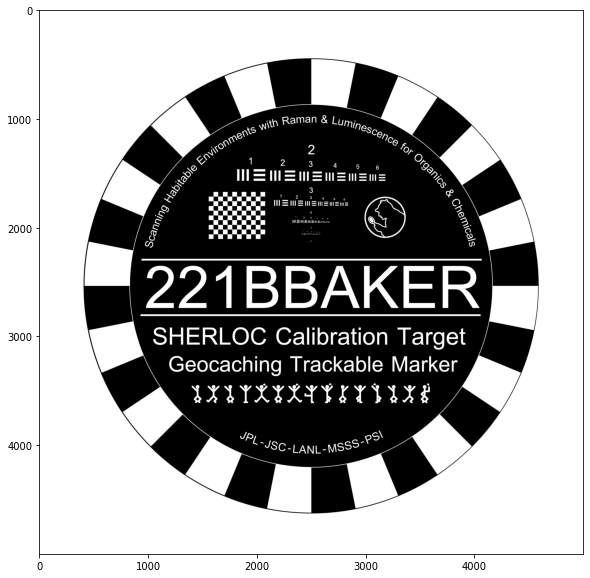

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(img);